In [1]:
# using Plots
using LinearAlgebra
using PyPlot

include("../smear_fem/src/fem.jl")
include("../smear_fem/src/PostProcess.jl")

Main.PostProcess

In [2]:
# test case 
x0 = 0
x1 = 1
y0 = 0
y1 = 1
ne = 20
h = (x1 - x0) / ne;

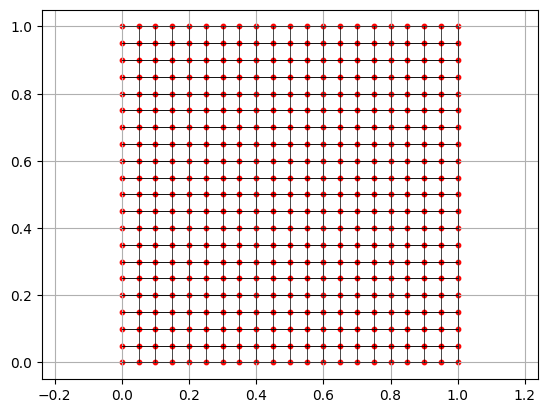

In [3]:
# set up mesh grid
function meshgrid(x0,x1,y0,y1,ne)
    x = collect(range(x0, x1, length=ne+1))
    y = collect(range(y0, y1, length=ne+1))
    
    NodeList = zeros(2,(ne+1)*(ne+1))

    k = 1
    for i in 1:ne+1
        for j in 1:ne+1
            NodeList[1,k] = x[j]
            NodeList[2,k] = y[i]
            k = k + 1
        end
    end

    IEN = zeros(Int64,ne*ne,4)
    
    l = 1
    for i in 1:ne
        for j in 1:ne
            IEN[l,1] = (i-1)*(ne+1) + j
            IEN[l,2] = (i-1)*(ne+1) + j + 1
            IEN[l,3] = i*(ne+1) + j + 1
            IEN[l,4] = i*(ne+1) + j
            l = l + 1
        end
    end

    return NodeList, IEN
end

NodeList, IEN = meshgrid(x0,x1,y0,y1,ne)


fig1 = plt.figure()
ax = fig1.add_subplot(111)

for i in 1:size(IEN,1)
    x = NodeList[1,IEN[i,:]]
    y = NodeList[2,IEN[i,:]]
    ax.plot(x, y, "-k", linewidth=0.5)
end

ax.scatter(NodeList[1,:],NodeList[2,:],s=10,c="r")
ax.axis("equal")
ax.grid("on")

gcf()

In [4]:
function setboundaryCond(NodeList, ne)
    # set dirichlet boundary conditions
    q_d = zeros((ne+1)*(ne+1),1)
    q_n = zeros((ne+1)*(ne+1),1)
    Dbound1 = 0
    Dbound2 = 1
    Nbound = 0

    # definition of the constraint matrix
    C = Matrix{Int}(I,(ne+1)*(ne+1),(ne+1)*(ne+1))

    for n in 1:length(q_d)
        coord = NodeList[:,n] # get the coordinates of the node
        if coord[2] == Dbound1 # bottom boundary
            q_d[n] = 0
        elseif coord[2] == Dbound2 # top boundary
            q_d[n] = 1
        end
    end

    for n in 1:length(q_n)
        coord = NodeList[:,n] # get the coordinates of the node
        if coord[1] == Nbound # left boundary
            q_n[n] = 0
        end 
    end

    C = C[:,(ne+2):((ne+1)*(ne+1)-(ne+1))]
    
    return q_d, q_n, C
end

q_d, q_n, C = setboundaryCond(NodeList, ne);

In [5]:
K = fem.assemble_system(ne, NodeList, IEN)

q_d, q_n, C = setboundaryCond(NodeList, ne)

# transpose the constraint matrix
C_t = transpose(C)

# extract the free part of the stiffness matrix
K_free = C_t*K*C

b = q_n - K*q_d

# solve the system
q_f = K_free\C_t*b

# assemble the solution 
q = q_d + C*q_f;

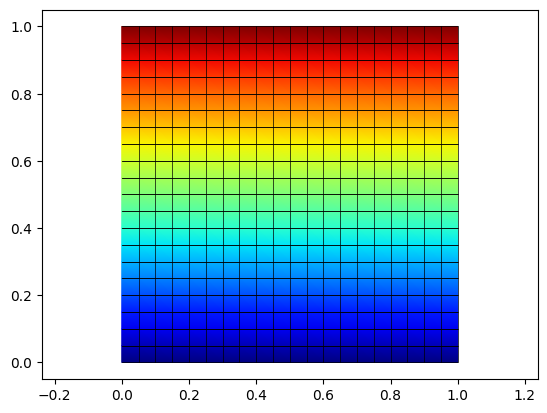

In [6]:
fig2 = plt.figure()
ax = fig2.add_subplot(111)
qList = PostProcess.noramlize(q, IEN)

for i in 1:size(IEN,1)
    x = NodeList[1,IEN[i,:]]
    y = NodeList[2,IEN[i,:]]
    c = qList[i,:]
    cmap = PostProcess.truncate_colormap(maximum(c), minimum(c))
    ax.tripcolor(x, y, c, cmap=cmap,shading="gouraud" )
    ax.plot(x, y, "-k", linewidth=0.5)
end

ax.axis("equal")
gcf()

In [7]:
PostProcess.write_vtk("vtkFiles/isoParam2d","u",NodeList,IEN,ne,q)

UndefVarError: UndefVarError: VTKCellTypes not defined